In [7]:
import boto3
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from io import BytesIO

# Function to convert Sentinel-2 TIFF image to RGB
def load_and_convert_tiff(image_path):
    with rasterio.open(image_path) as src:
        # Read the red, green, and blue bands (B4, B3, B2)
        red_band = src.read(4)
        green_band = src.read(3)
        blue_band = src.read(2)

        # Stack the bands to create an RGB image
        rgb = np.stack([red_band, green_band, blue_band], axis=-1)

        # Normalize to [0, 255]
        rgb_normalized = np.clip((rgb / np.max(rgb)) * 255, 0, 255).astype(np.uint8)

        return rgb_normalized

# Function to process all images in the S3 bucket
def process_all_images_in_bucket(bucket_name, prefix, mask_generator):
    s3 = boto3.client('s3')
    response = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix)
    
    # Iterate through all image objects in the S3 bucket
    for obj in response.get('Contents', []):
        img_path = obj['Key']
        
        # Load the image from S3
        s3_response = s3.get_object(Bucket=bucket_name, Key=img_path)
        image = load_and_convert_tiff(BytesIO(s3_response['Body'].read()))
        
        try:
            # Generate masks for the current image
            masks = mask_generator.generate(image)

            # Visualization
            plt.figure(figsize=(20, 20))
            plt.imshow(image)
            show_anns(masks)
            plt.axis('off')
            plt.show()

            # Save the masks or process them as needed

        except Exception as e:
            print(f"Mask generation failed for {img_path}: {str(e)}. Skipping...")


In [20]:

image_s3_prefix = 's3://solafune/test_images/images/test_0.tif'

image =load_and_convert_tiff(image_s3_prefix)

# Get the height and width of the image
height, width = image.shape[:2]

# Create a mask of ones with the same height and width as the image
mask = np.ones((height, width), dtype=np.uint8)

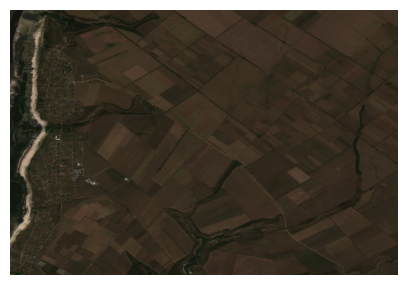

In [22]:
plt.figure(figsize=(5, 5))
plt.imshow(image)
plt.axis('off')
plt.show()


In [23]:
print(mask.shape)
print(img.shape)

(802, 1171)
(802, 1171, 3)


In [ ]:
# segment image region using  fine tune model
# See Train.py on how to fine tune/train the model
import numpy as np
import torch
import cv2
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

# use bfloat16 for the entire script (memory efficient)
torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

num_samples = 30 # number of points/segment to sample
def get_points(mask,num_points): # Sample points inside the input mask
        points=[]
        for i in range(num_points):
            coords = np.argwhere(mask > 0)
            yx = np.array(coords[np.random.randint(len(coords))])
            points.append([[yx[1], yx[0]]])
        return np.array(points)
input_points = get_points(mask,num_samples)
# read image and sample points


# Load model you need to have pretrained model already made
sam2_checkpoint =  "./segment-anything-2/checkpoints/sam2_hiera_large.pt" # "sam2_hiera_large.pt"
model_cfg = "sam2_hiera_l.yaml" # "sam2_hiera_l.yaml"
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda")

# Build net and load weights
predictor = SAM2ImagePredictor(sam2_model)
predictor.model.load_state_dict(torch.load("model_large.torch"))

# predict mask

with torch.no_grad():
        predictor.set_image(image)
        masks, scores, logits = predictor.predict(
            point_coords=input_points,
            point_labels=np.ones([input_points.shape[0],1])
        )

# Short predicted masks from high to low score

masks=masks[:,0].astype(bool)
shorted_masks = masks[np.argsort(scores[:,0])][::-1].astype(bool)

# Stitch predicted mask into one segmentation mask

seg_map = np.zeros_like(shorted_masks[0],dtype=np.uint8)
occupancy_mask = np.zeros_like(shorted_masks[0],dtype=bool)
for i in range(shorted_masks.shape[0]):
    mask = shorted_masks[i]
    if (mask*occupancy_mask).sum()/mask.sum()>0.15: continue
    mask[occupancy_mask]=0
    seg_map[mask]=i+1
    occupancy_mask[mask]=1

# create colored annotation map
height, width = seg_map.shape

# Create an empty RGB image for the colored annotation
rgb_image = np.zeros((seg_map.shape[0], seg_map.shape[1], 3), dtype=np.uint8)
for id_class in range(1,seg_map.max()+1):
    rgb_image[seg_map == id_class] = [np.random.randint(255), np.random.randint(255), np.random.randint(255)]

# save and display

cv2.imwrite("annotation.png",rgb_image)
cv2.imwrite("mix.png",(rgb_image/2+image/2).astype(np.uint8))

cv2.imshow("annotation",rgb_image)
cv2.imshow("mix",(rgb_image/2+image/2).astype(np.uint8))
cv2.imshow("image",image)
cv2.waitKey()